# Split Arrivals and Departures and Convert to People


## Create Arrivals and Departures
1. distribute parking first
2. create arrivals 
3. convert to cars

> This module will take your selected demand day and split your total demand between arriving patrons and 
> departing patrons and save the resulting DataFrame to file. Note: departures will get all round-off up where
> the total people are odd.

```python
def distributeParking(day_demand,
                      columns):
```
> - **day_demand:** *DataFrame* - is the demand dataframe that was selected from the "select a day" module
> - **columns:** *list* - the terminal names parking will be distributed over


```python
def create_depart_arrive(day_demand,
                     percent_of_arrivals=.5,
                     percent_of_departure=.5):
```
> - **day_demand:** *DataFrame* - is the demand dataframe that was selected from the "select a day" module
> - **percent_of_arrivals:** *Float* - is the percent we assume to be arrival trips. This will default to 50%
> - **percent_of_departure:** *Float* - is the percent we assume to be departing trips. this will default to 50%
> - **Note:** arrivals and departures must add to 1

## Convert Cars to People
This moldule will convert the number of cars to people. Note: our current model only accounts for a certian percentage of the total cars. Thus, more calculations will need to done later on when generating the trips files
```python
def cars_to_people(df,
                   peoplePerCar=1.7): 
```
> - **df:** *DataFrame* - is a DataFrame generated from the `create_depart_arrive()` function
> - **peoplePerCar:** *Integer* - is the ratio of people to cars. Defualt is `1.7` people to cars.


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import sys
sys.path.insert(0, os.path.abspath('../Generate_SUMO_demand/'))
import DFW_gen_flow as gf
from tqdm import tqdm_notebook
import math

## Please Pick a Day Before moving on

In [31]:
Date = '2018-6-11' 
selected = pd.read_csv("selected_demand.csv",index_col=[0])
selected

,Date,Volume_Category
0,2017-10-16,high
1,2017-10-28,low
2,2017-10-17,medium
3,2017-11-22,high
4,2017-11-30,medium
5,2017-11-24,low
6,2017-12-21,high
7,2017-12-28,medium
8,2017-12-2,low
9,2018-1-2,high


In [60]:
def distributeParking(demand,columns):
    for i,parking in enumerate(tqdm_notebook(demand['parking'])):
        np.random.shuffle(columns)
        length = len(columns)
        allotment = np.floor(parking/length)
        remaining = parking
        for c in columns:
            if c == columns[-1]:
                demand[c].loc[i]+=remaining
            else:
                demand[c].loc[i]+=allotment
            remaining-=allotment
            
def create_depart_arrive(day_demand,
                         percent_of_arrivals=.5,
                         percent_of_departure=.5):
    assert percent_of_arrivals + percent_of_departure == 1,"Please ensure your arrivals and departures add to 1"
    cars = pd.DataFrame() 
    
    columns = ['A','B','C','D','E']
    for col in columns:
        tmp_arrival = []
        tmp_departure = []
        for row in day_demand[col]:
            tmp_arrival.append(math.floor(row * percent_of_arrivals))
            tmp_departure.append(math.ceil(row * percent_of_departure))

        cars['Arrive_' + col] = tmp_arrival
        cars['Depart_' + col] = tmp_departure
    
    cars['Time'] = day_demand['time']
#     cars['parking'] = day_demand['parking']
    cars['pass_thru'] = day_demand['pass']
    return cars

def cars_to_people(df,peoplePerCar=1.7,percentOfTransit=.005):  
    columns = ['Arrive_A','Arrive_B','Arrive_C','Arrive_D','Arrive_E',
               'Depart_A','Depart_B','Depart_C','Depart_D','Depart_E']
    tmp_df = pd.DataFrame()
    for col in columns:
        tmp_people = []
        for row in df[col]:
            tmp_people.append(round((row * peoplePerCar/(1-percentOfTransit))))
        tmp_df[col + "_people"] = tmp_people
    depart_columns = []
    arrive_columns = []
    for col in tmp_df.columns:
        if col.startswith('Depart'):
            depart_columns.append(col)
        elif col.startswith('Arrive'):
            arrive_columns.append(col)
    tmp_df['Depart_total'] = tmp_df[depart_columns].sum(axis=1)
    tmp_df['Arrival_total'] = tmp_df[arrive_columns].sum(axis=1)
    
    tmp_df['pass_thru'] = df['pass_thru']
    tmp_df['Total'] = tmp_df[['Depart_total','Arrival_total']].sum(axis=1)
    return tmp_df


In [64]:
# for Date in selected['Date']:
#     folder = "../Example_Files/Demand_CSV"
#     level = selected.loc[selected['Date'] == Date]['Volume_Category'].item()
#     file_name = Date + '.' + level +".cars.csv"
#     demand = pd.read_csv(os.path.join(folder,file_name))
#     distributeParking(demand,['A','B','C','D','E'])
#     cars = create_depart_arrive(demand,.5,.5)
#     people_demand = cars_to_people(cars,1.7)
#     people_demand.head()
#     file_name = Date + '.' + level + ".people.csv"
#     people_demand.to_csv(os.path.join(folder,file_name))

In [61]:
folder = "../Example_Files/Demand_CSV"
level = selected.loc[selected['Date'] == Date]['Volume_Category'].item()
file_name = Date + '.' + level +".cars.csv"
demand = pd.read_csv(os.path.join(folder,file_name))
demand.head()

,time,scheduled_fight_time,parking,pass,A,B,C,D,E,month,day,year,DateTime,Date,Total
0,00:00:00,2018-06-11 00:00:00,17.0,26.0,168,98,177,105,10,6,11,2018,2018-06-11 00:00:00,2018-6-11,601.0
1,00:30:00,2018-06-11 00:30:00,8.0,15.0,124,64,134,50,8,6,11,2018,2018-06-11 00:30:00,2018-6-11,403.0
2,01:00:00,2018-06-11 01:00:00,13.0,16.0,96,53,116,65,7,6,11,2018,2018-06-11 01:00:00,2018-6-11,366.0
3,01:30:00,2018-06-11 01:30:00,9.0,22.0,80,45,94,40,5,6,11,2018,2018-06-11 01:30:00,2018-6-11,295.0
4,02:00:00,2018-06-11 02:00:00,16.0,14.0,58,35,69,31,4,6,11,2018,2018-06-11 02:00:00,2018-6-11,227.0


## Ensure your arrival, departure and cars to people ratio are what you want

In [62]:
distributeParking(demand,['A','B','C','D','E']) 
cars = create_depart_arrive(demand,.5,.5)
people_demand = cars_to_people(cars,1.7)
file_name = Date + '.' + level + ".people.csv"
people_demand.to_csv(os.path.join(folder,file_name))
people_demand.head()

,Arrive_A_people,Arrive_B_people,Arrive_C_people,Arrive_D_people,Arrive_E_people,Depart_A_people,Depart_B_people,Depart_C_people,Depart_D_people,Depart_E_people,Depart_total,Arrival_total,pass_thru,Total
0,145,85,155,92,10,147,87,155,92,12,493,487,26.0,980
1,106,55,118,43,7,108,56,118,44,9,335,329,15.0,664
2,84,46,101,56,10,84,48,101,58,10,301,297,16.0,598
3,72,39,80,34,5,73,39,82,36,5,235,230,22.0,465
4,53,32,62,29,5,53,32,62,29,7,183,181,14.0,364


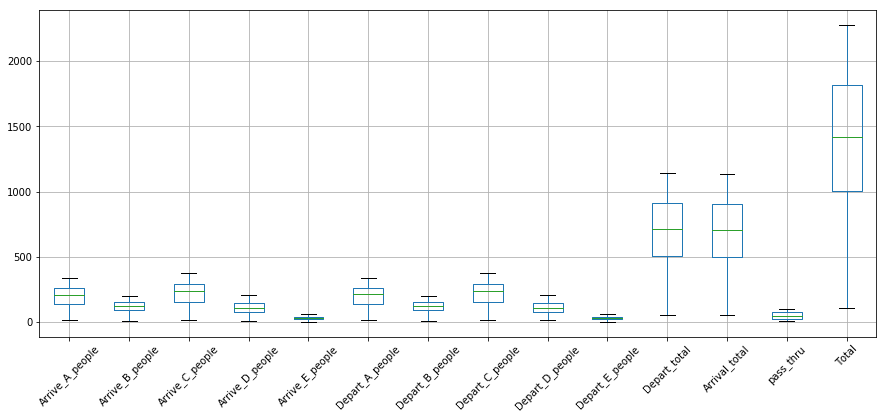

In [65]:
people_demand.boxplot(figsize=(15,6),rot=45)